<a href="https://colab.research.google.com/github/AnanyaUp/Biomedical-NER-BiomedBERT/blob/main/NER(BiomedBERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q torch==2.3.1 transformers==4.39.3 datasets==2.19.0 tokenizers==0.15.2 seqeval


In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os, json
from datasets import load_dataset

data_dir = "/content/drive/MyDrive/bc5cdr"

dataset = load_dataset(
    "json",
    data_files={
        "train": os.path.join(data_dir, "train.json"),
        "validation": os.path.join(data_dir, "valid.json"),
        "test": os.path.join(data_dir, "test.json"),
    }
)

print(dataset)


Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tags', 'tokens'],
        num_rows: 5865
    })
})


In [6]:
#labels
with open(os.path.join(data_dir, "label.json"), "r") as f:
    labels = json.load(f)
    id2label = {str(i): label for i, label in enumerate(labels)}
    label2id = {v: k for k, v in id2label.items()}

print(id2label)

{'0': 'O', '1': 'B-Chemical', '2': 'B-Disease', '3': 'I-Disease', '4': 'I-Chemical'}


In [7]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    all_labels = []
    for i, labels in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx] if word_idx < len(labels) else -100)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        # Ensure label length == input length
        if len(label_ids) < len(tokenized_inputs["input_ids"][i]):
            label_ids += [-100] * (len(tokenized_inputs["input_ids"][i]) - len(label_ids))
        elif len(label_ids) > len(tokenized_inputs["input_ids"][i]):
            label_ids = label_ids[:len(tokenized_inputs["input_ids"][i])]

        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [8]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
print(tokenized_datasets)


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5865
    })
})


In [9]:
sample = tokenized_datasets["train"][0]
print(len(sample["input_ids"]), len(sample["labels"]))


128 128


In [10]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    keys = ["input_ids", "attention_mask", "labels"]
    batch_out = {k: [torch.tensor(ex[k]) for ex in batch] for k in keys}
    batch_out = {k: torch.nn.utils.rnn.pad_sequence(v, batch_first=True, padding_value=0) for k, v in batch_out.items()}
    return batch_out


In [11]:
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8, collate_fn=collate_fn)

print(" Dataloaders ready!")


 Dataloaders ready!


In [12]:
from transformers import AutoModelForTokenClassification, AdamW

num_labels = len(label2id)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from tqdm.auto import tqdm
import torch

num_epochs = 3
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        avg_loss = total_loss / (len(progress_bar) + 1e-8)
        progress_bar.set_postfix({"loss": f"{avg_loss:.4f}"})  # updates live on the same bar

    print(f" Epoch {epoch+1}/{num_epochs} completed | Avg Loss: {avg_loss:.4f}\n")

print(" Training finished successfully!")


Epoch 1/3:   0%|          | 0/654 [00:00<?, ?it/s]

 Epoch 1/3 completed | Avg Loss: 0.1279



Epoch 2/3:   0%|          | 0/654 [00:00<?, ?it/s]

 Epoch 2/3 completed | Avg Loss: 0.0410



Epoch 3/3:   0%|          | 0/654 [00:00<?, ?it/s]

 Epoch 3/3 completed | Avg Loss: 0.0223

 Training finished successfully!


In [18]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

def evaluate_ner(model, dataloader, id_to_label, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=True):
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            labels = batch["labels"].cpu().numpy()
            preds = predictions.cpu().numpy()
            attention_mask = batch["attention_mask"].cpu().numpy()

            for pred, label, mask in zip(preds, labels, attention_mask):
                true_labels = []
                true_preds = []
                for p, l, m in zip(pred, label, mask):
                    if m == 1 and l != -100:  # ignore padded tokens and special tokens
                        true_labels.append(id_to_label[str(l)])
                        true_preds.append(id_to_label[str(p)])
                all_labels.append(true_labels)
                all_preds.append(true_preds)

    print("📊 Classification Report:\n")
    # Filter out labels that are not present in the true labels
    unique_labels = sorted(list(set([item for sublist in all_labels for item in sublist])))
    print(classification_report(all_labels, all_preds, digits=4))
    print("F1:", f1_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds))
    print("Recall:", recall_score(all_labels, all_preds))
    return all_preds, all_labels

In [19]:
import matplotlib.pyplot as plt

# Run evaluation first to get metrics
all_preds, all_labels = evaluate_ner(model, val_dataloader, id2label, device)

# Compute overall metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

Evaluating:   0%|          | 0/667 [00:00<?, ?it/s]

📊 Classification Report:

              precision    recall  f1-score   support

    Chemical     0.9291    0.9575    0.9431      5339
     Disease     0.8408    0.8562    0.8484      4236

   micro avg     0.8903    0.9127    0.9013      9575
   macro avg     0.8849    0.9069    0.8958      9575
weighted avg     0.8900    0.9127    0.9012      9575

F1: 0.9013459852508897
Precision: 0.8902811735941321
Recall: 0.9126892950391645


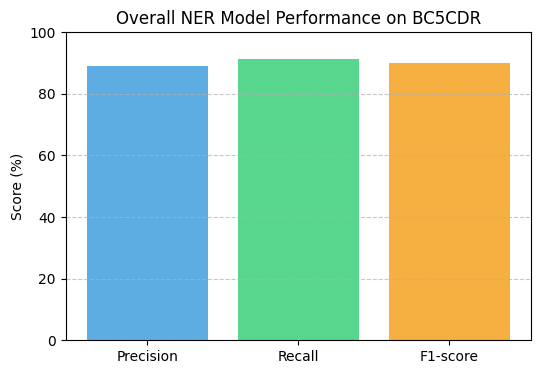

In [20]:
metrics = {
    "Precision": precision * 100,
    "Recall": recall * 100,
    "F1-score": f1 * 100
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['#5DADE2','#58D68D','#F5B041'])
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("Overall NER Model Performance on BC5CDR")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
